In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn import cluster, datasets, mixture, metrics
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

%matplotlib inline

In [50]:
random_state = 170
X, y = datasets.make_blobs(n_samples=1500, random_state=100)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)

aniso_df = pd.DataFrame(X_aniso)
aniso_df

,0,1
0,-3.619581,6.304440
1,-3.273795,6.061828
2,-4.470572,2.143446
3,-4.523249,7.702503
4,-3.400372,0.556899
...,...,...
1495,3.347981,-5.280782
1496,-3.028512,5.734996
1497,-2.663227,-0.604468
1498,1.310679,-2.679928


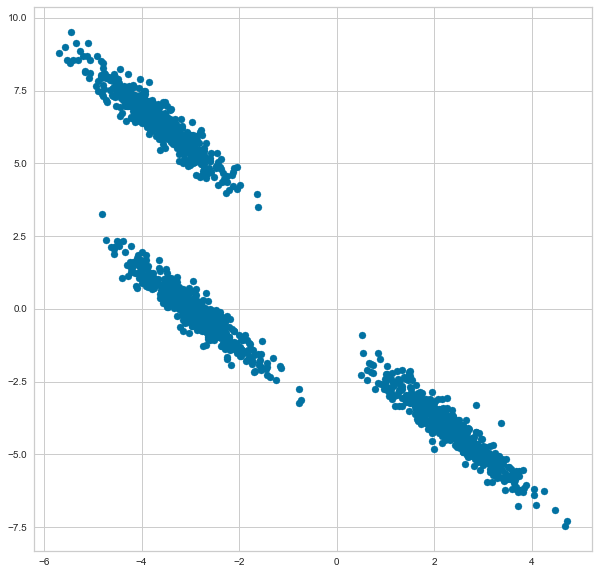

In [51]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.scatter(aniso_df[0], aniso_df[1])
plt.show()

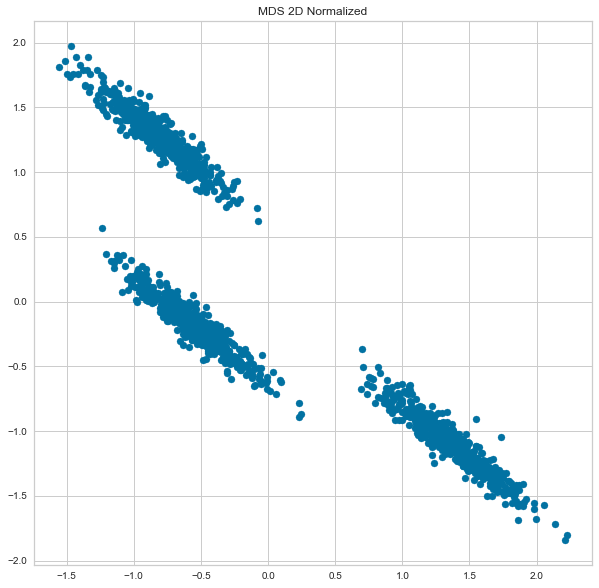

In [54]:
n = StandardScaler().fit_transform(aniso_df)
scaled_features_transformed = pd.DataFrame(n, index=aniso_df.index, columns=aniso_df.columns)

fig_mds = plt.figure(figsize=(10, 10))

ax_mds = fig_mds.add_subplot()
plt.scatter(scaled_features_transformed[0], scaled_features_transformed[1])
plt.title('MDS 2D Normalized')
plt.show()

To get consistent and correct results, normalization has to be performed.

In [55]:
scaled_features_df = scaled_features_transformed

# Agglomarative Clustering (Hierarchical)

As with the large dataset, I'll be starting to try agglomarative clustering.

This method builds up a dendogram and uses a distance metric to determin which datapoints should be grouped together. It starts by viewing each datapoint as a separate group and iteratively groups them together (as seen in the dendogram below).

It yielded the following results:

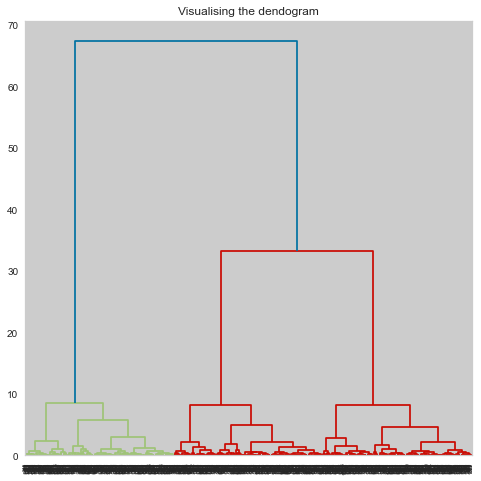

In [56]:
plt.figure(figsize =(8, 8))
plt.title('Visualising the dendogram')
Dendrogram = shc.dendrogram((shc.linkage(scaled_features_df, method ='ward')))

For n_clusters = 2 The average silhouette_score is : 0.6882629237972031
For n_clusters = 3 The average silhouette_score is : 0.7490411696630135
For n_clusters = 4 The average silhouette_score is : 0.6360567870549237
For n_clusters = 5 The average silhouette_score is : 0.5505320727845893
For n_clusters = 6 The average silhouette_score is : 0.49787820712352476


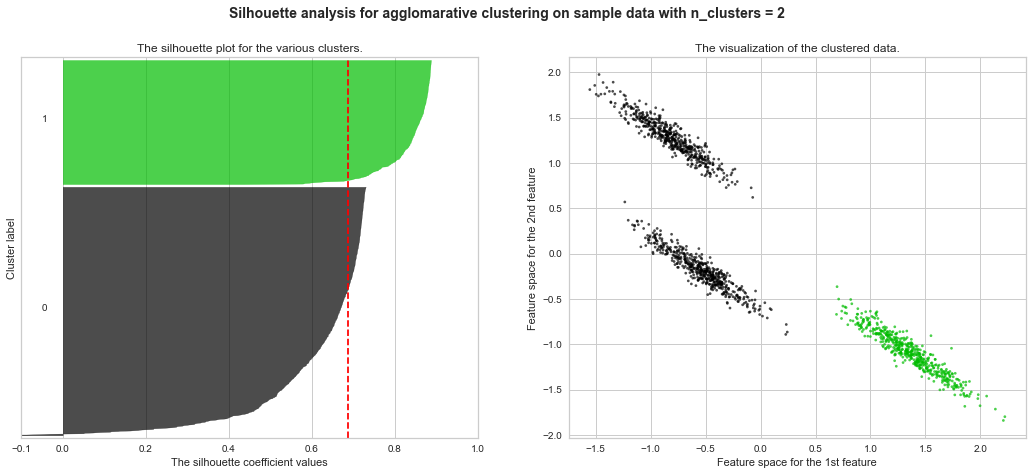

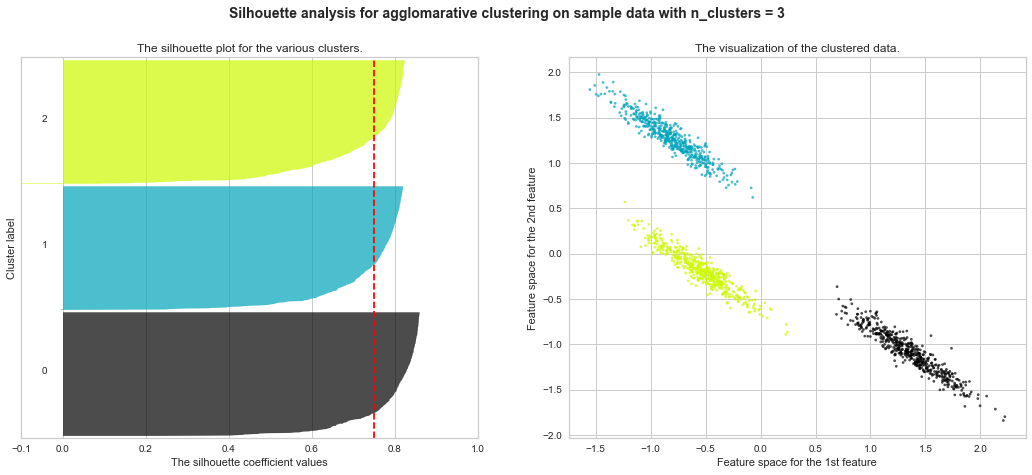

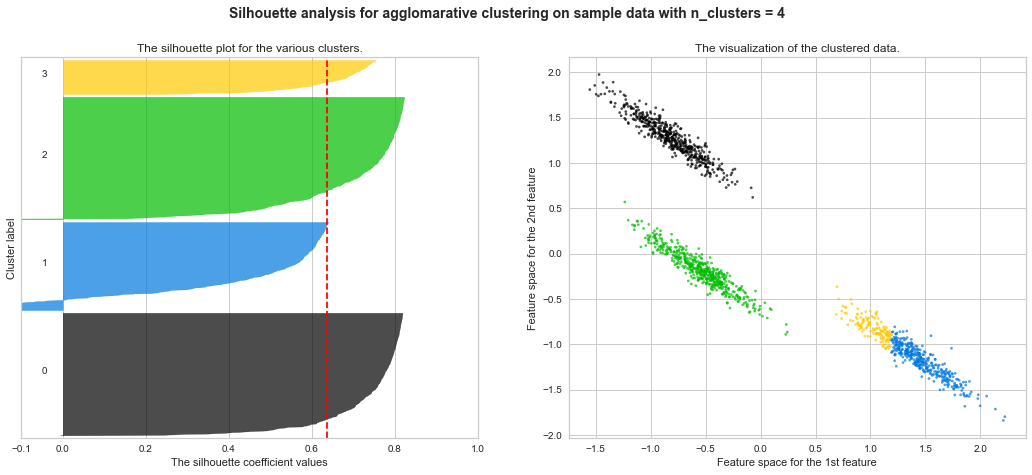

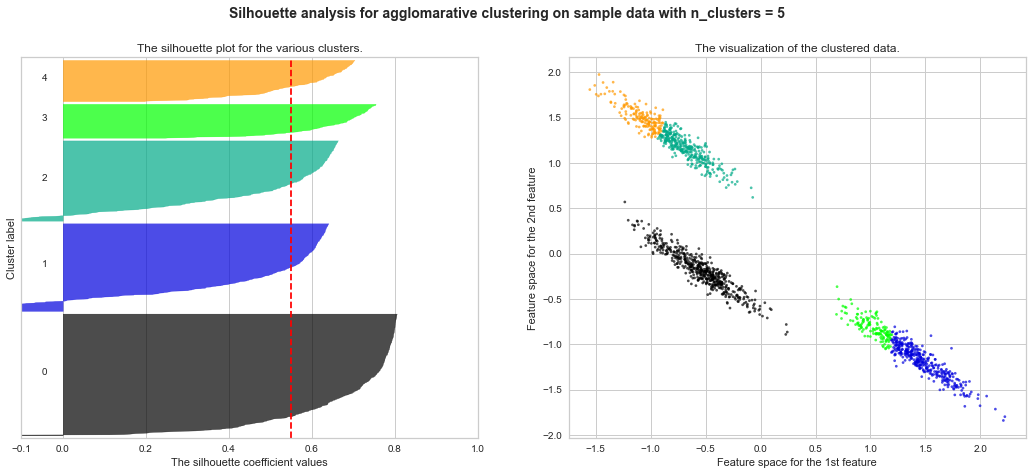

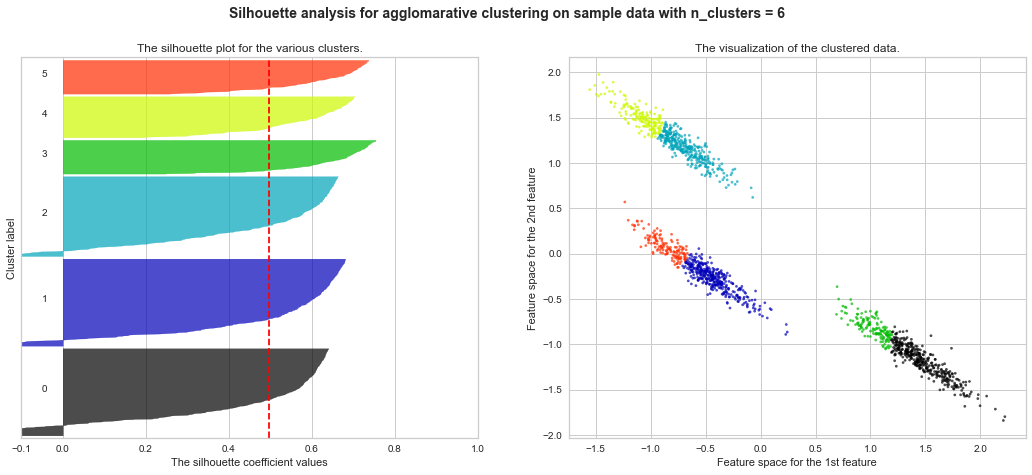

In [57]:
clustersList = [2,3,4,5,6]

for n_clusters in clustersList:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_features_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.AgglomerativeClustering(n_clusters = n_clusters)
    cluster_labels = clusterer.fit_predict(scaled_features_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(scaled_features_df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(scaled_features_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        scaled_features_df[0], scaled_features_df[1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for agglomarative clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In contrast to the datasetes used for the small-/large-dataset-analysis, here distinct clusters are visible and can be discerned even when looking at the plots. This becomes even more obvious when looking at the silhouette average silhouette values: 3 clusters show an average silhouette score of above 0.74, which is much higher than any achieved analyzing the small- and large datasets.

Some of the individual silhouette scores with 3 clusters are even above 0.8 showing a particularly good fit within the assigned cluster.

Looking at the plots, it comes as no surprise that 3 clusters is the optimum number of clusters. Agglomarative clusterin works well wich this cluster shape. All three clusters have been detected correctly. Even the nois around the clusters (outliers) have been correctly assigned to the nearest cluster.

# Gaussian Mixture (Partitive Clustering)

Since the data is strongly clumped up, I expected not to find a useful difference between the available partitive clustering methods known to me.

As partitive clustering method, it needs a number as the basis for the number of clusters to produce. It is based ona probabilistic model which assumes all the datapoints are created using a gaussian distribution. Datapoints can belong to multiple clusters (probability is provided).

Therefore I chose to try gaussian mixture, which yielded the following results:

For n_clusters = 2 The average silhouette_score is : 0.6882629237972031
For n_clusters = 3 The average silhouette_score is : 0.7490411696630135
For n_clusters = 4 The average silhouette_score is : 0.6581123106458825
For n_clusters = 5 The average silhouette_score is : 0.5674735751805174
For n_clusters = 6 The average silhouette_score is : 0.551142539796173


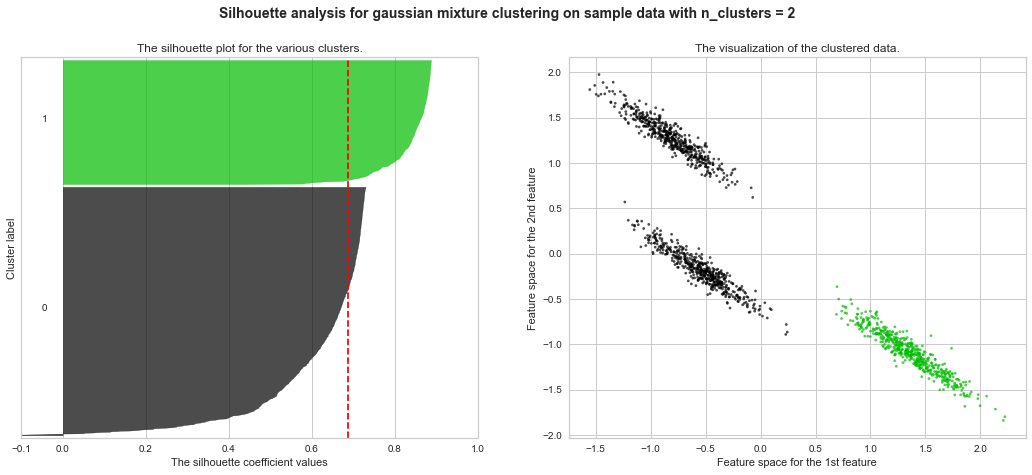

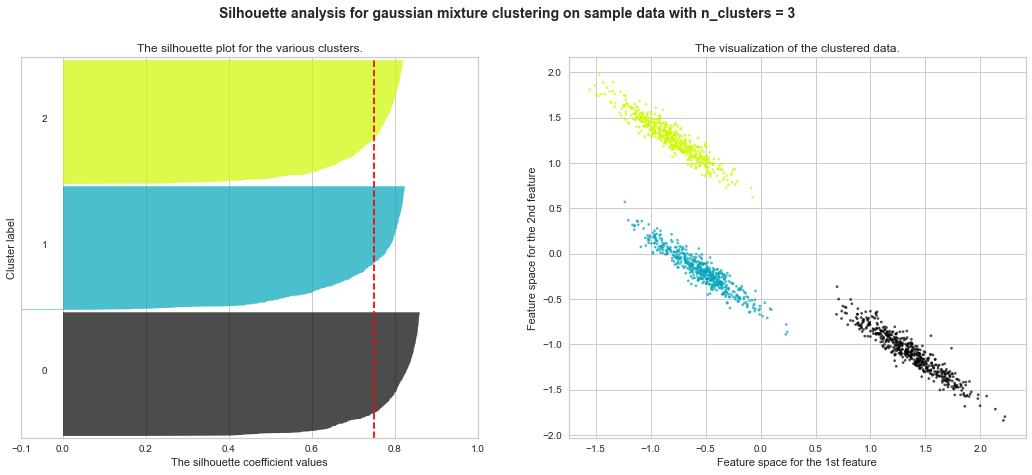

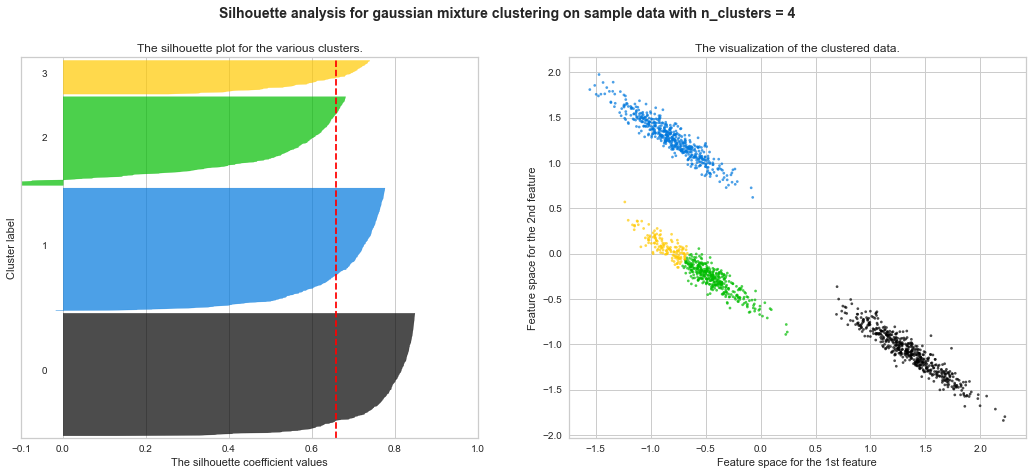

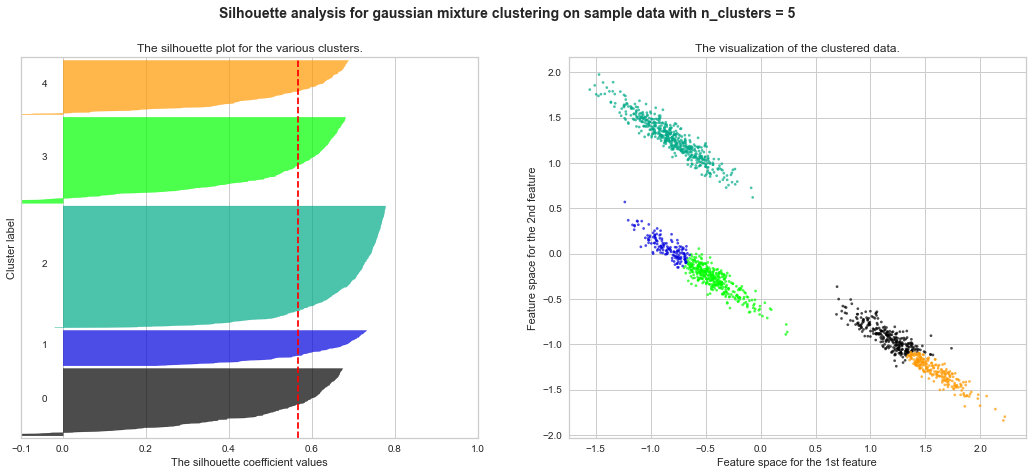

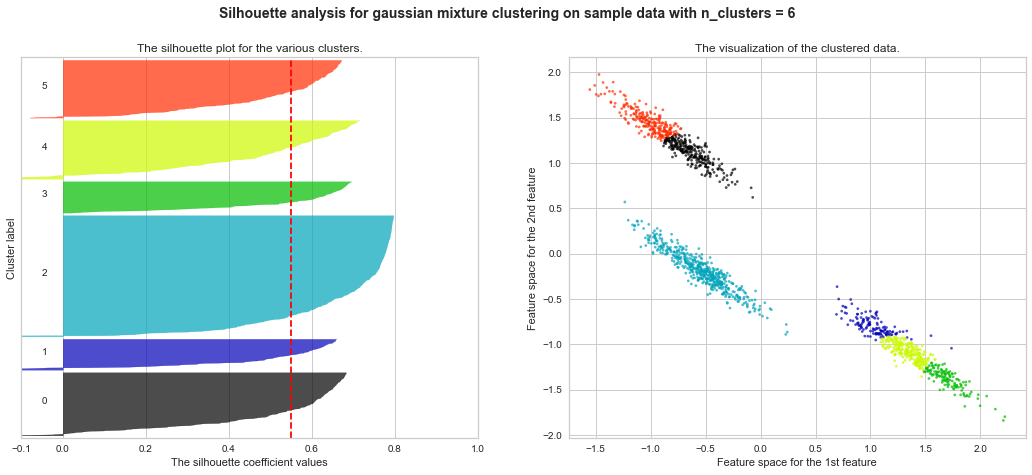

In [59]:
clustersList = [2,3,4,5,6]

for n_clusters in clustersList:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_features_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components = n_clusters)
    cluster_labels = clusterer.fit_predict(scaled_features_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(scaled_features_df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(scaled_features_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        scaled_features_df[0], scaled_features_df[1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for gaussian mixture clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Gaussian mixture does an equally good job of detecting the clusters. An average silhouette value of above 0.74 with 3 clusters is the optimum here as well.

Individual silhouette values of above 0.8 are being achieved as well with 3 clusters.

# DBSCAN

Next, I was interested in how the result would look like when using DBSCAN. It clusters by analyzing the density of the datapoints and clustering dens "areas" to one cluster.

For n_clusters = 2 The average silhouette_score is : 0.5308869436864023
For n_clusters = 2 The average silhouette_score is : 0.5308869436864023
For n_clusters = 3 The average silhouette_score is : 0.7490411696630135
For n_clusters = 3 The average silhouette_score is : 0.7490411696630135
For n_clusters = 4 The average silhouette_score is : 0.7013133877269514


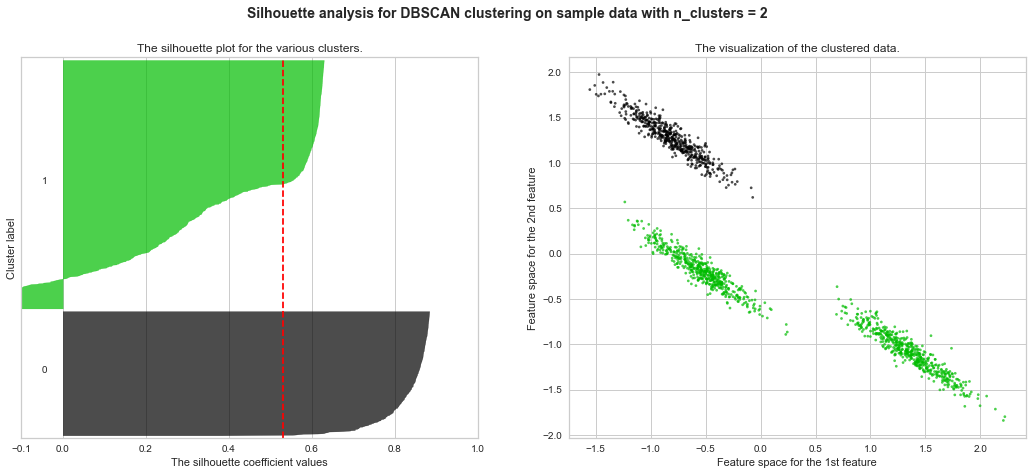

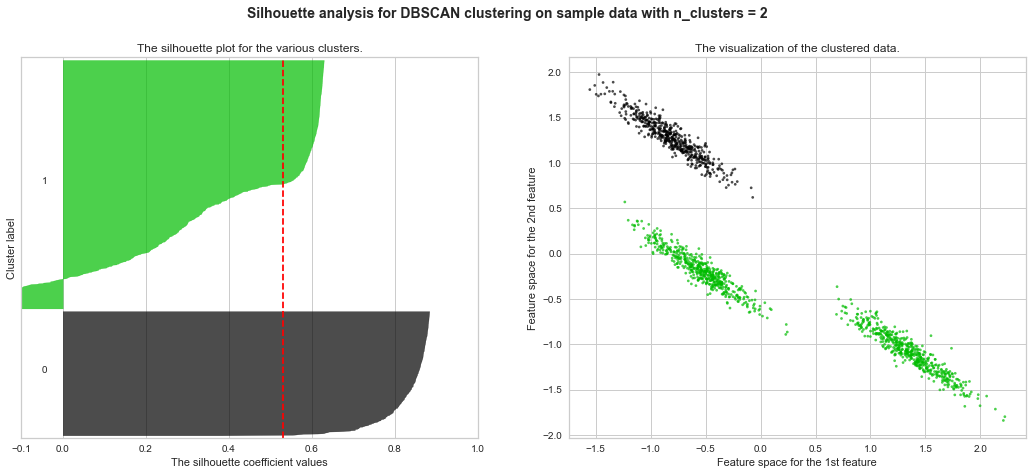

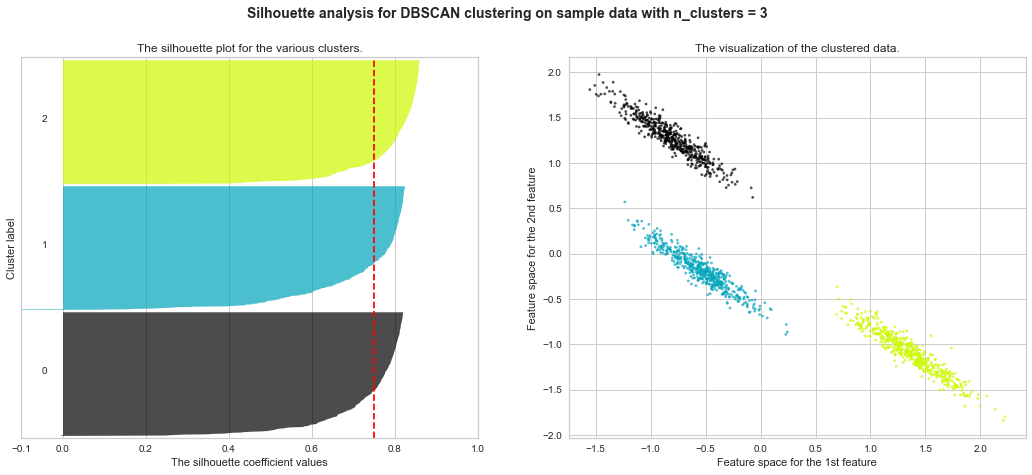

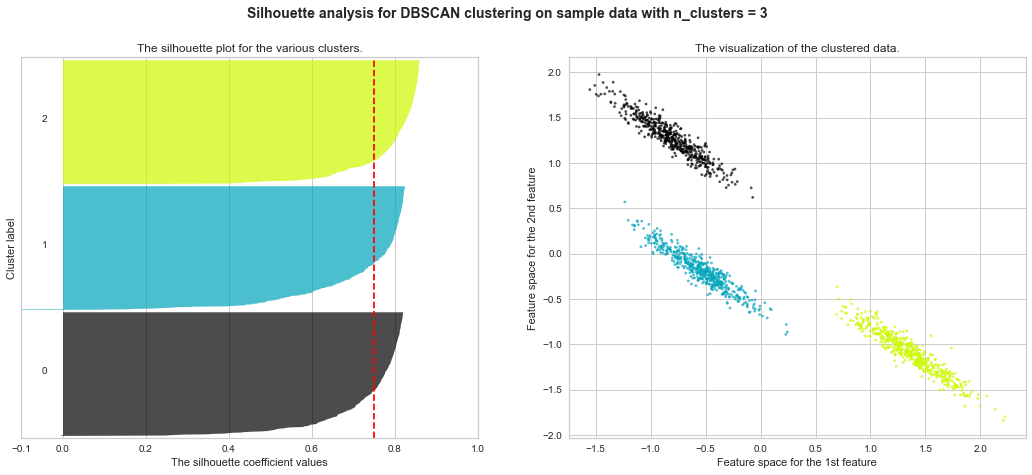

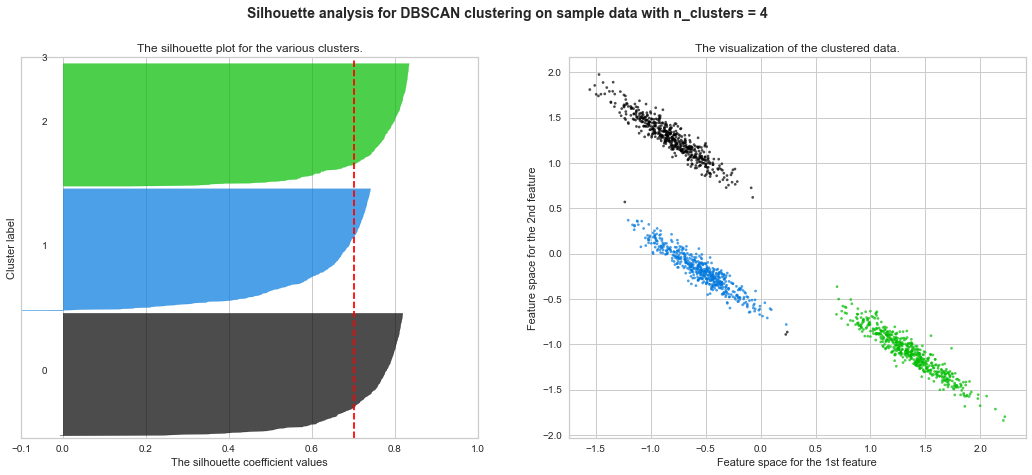

In [66]:
epsList = [0.6, 0.5, 0.4, 0.3, 0.2]

for eps in epsList:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.DBSCAN(algorithm='kd_tree', min_samples=5, eps=eps)
    cluster_labels = clusterer.fit_predict(scaled_features_df)
    _, counts = np.unique(cluster_labels, return_counts=True)
    n_clusters = len(counts)

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_features_df) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(scaled_features_df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(scaled_features_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        scaled_features_df[0], scaled_features_df[1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for DBSCAN clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


    # db = cluster.DBSCAN(algorithm='kd_tree', min_samples=5, eps=eps)
    # clustering = db.fit_predict(scaled_features_df)
    # # Visualizing the clustering
    # plt.figure(figsize =(10,10))
    # plt.title('maximum distance: ' + str(eps))
    # plt.scatter(scaled_features_df['wage per hour'], scaled_features_df['age'], 
    #         c = clustering, cmap ='rainbow')
    # plt.show()

Trying different values for the eps-parameter (maximum distance between two samples to be considered as in the neighborhood), again, 3 clusters seems to be the optimum number of clusters. The average silhouette value is again above 0.74 with some individual values above 0.8 in all three clusters.